In [16]:
import importlib
import pandas as pd
import numpy as np
import time
import requests
import json
from matplotlib import pyplot as plt
from influxdb_client_3 import InfluxDBClient3
from queryDSL import InfluxQueryBuilder, QueryFilter, QueryAggregation, Range, RelativeRange

In [17]:
INFLUXDB_TOKEN="VJK1PL0-qDkTIpSgrtZ0vq4AG02OjpmOSoOa-yC0oB1x3PvZCk78In9zOAGZ0FXBNVkwoJ_yQD6YSZLx23WElA=="
token = INFLUXDB_TOKEN
org = "Realtime Big Data"
host = "https://us-east-1-1.aws.cloud2.influxdata.com"
influx_client = InfluxDBClient3(host=host, token=token, org=org)
resetUrl = "http://127.0.0.1:5000/api/reset"
cacheUrlJson = "http://127.0.0.1:5000/api/query"

# Step 1: Generating Queries

## InfluxQL
InfluxQL is a custom language supported by InfluxDB, it has very similar syntax to regular SQL, but provides a richer syntax for aggregation and time based queries, making it much easier to write for time-series use cases 

## Query DSL
We Created a DSL which allows us to convert InfluxQL Queries to Python Objects and to JSON objects. This allows us to easily manipulate queries and create new ones. It also allows us to potentially use the cache in a platform agnostic way by creating abstractions over core query features. 
Additionally, this also provides validation operations and default naming of parameters, ensuring consistency across our systems.

## Test Setup and Data:
We created a data generation job which generates data to InfluxDB constantly. We write to a single table called system_metrics, simulating some of the measurements an infrastructure team would want to monitor over a huge number of servers.

The schema for the data is as follows:
Table: system_metrics
| time     | platform | host     | cpu_usage | temperature | memory_usage|
| -------- | -------- | -------- | --------- | ----------- | ----------- |
| 13214214   | windows   | host1   | 32.1312    | 37.2123      | 10.1232      |
| 13214215   | mac_os   | host2   | 32.1312    | 37.2123      | 37.2123      |

In reality, the time series databases don't store all tags in a single table. Rather, it stores individual series(s) if data which represent a unique combination of tags
So, the table can be more accurately represented as 

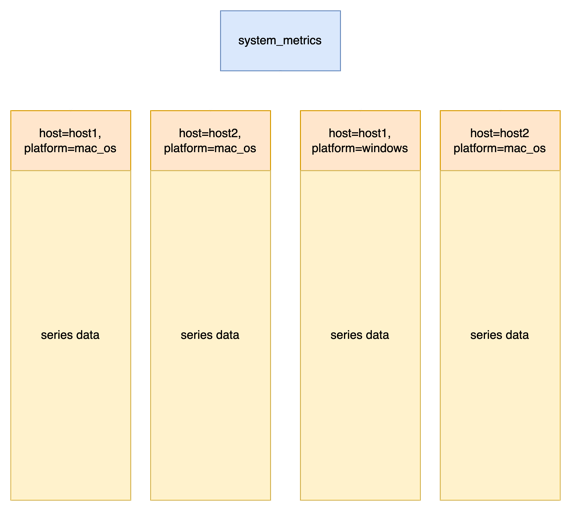

## Query Plans and Optimisation
Queries in InfluxDB are typically executed as follows
1. Search for relavant Series using Inverted Index
2. Search for start and end time ranges within each series
3. Merge series which require merging
4. Perform window downsampling using aggregation function
5. Combine results and return

Our implementation essentially simplifies step 2 and 4 since
1. Since we know that data returned comes in fixed-sized windows, we can easily index into the required positions without search
2. Since data is pre-aggregated, we don't need to perform expensive aggregation operations over large amounts of data

## Queries
We created a suite of queries which simulate what a dashboard might show, as well as different queries a user might perform when analysing system metrics over time

1. Query 1: Base query - show cpu_usage and temperature over the last 5 hours, in 1 minute intervals grouped by host and platform
2. Query 2: Now show me cpu_usage and memory_usage over the same time period, in 1 minute intervals grouped by host and platform
3. Query 3: Extend the range shown - show me cpu_usage and temperature again over the last 10 hours, in 1 minute intervals grouped by host and platform
4. Query 4: Change the groups used - Analyse the same data by platform instead
5. Query 5: Downsample the data. Show me less granularity, using 2 minute intervals instead of 1 minute intervals
6. Query 6: Now show me platform based statistics over 3 minute intervals instead
7. Query 7: Show me all statistics over 10 minute aggregation windows


In [18]:
influxBuilder = (InfluxQueryBuilder()
               .withBucket("Test")
               .withMeasurements(["cpu_usage", "temperature"])
               .withTable("system_metrics")
               .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
               .withAggregate(QueryAggregation("1m", "mean", False))
               .withRelativeRange('300m', None)
               .withGroupKeys(["host", "platform"])
       )

influxBuilderMeasurements = (InfluxQueryBuilder()
               .withBucket("Test")
               .withMeasurements(["cpu_usage", "memory_usage"])
               .withTable("system_metrics")
               .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
               .withAggregate(QueryAggregation("1m", "mean", False))
               .withRelativeRange('300m', None)
               .withGroupKeys(["host", "platform"])
       )

influxBuilderExtendedRange = (InfluxQueryBuilder()
               .withBucket("Test")
               .withMeasurements(["cpu_usage", "temperature"])
               .withTable("system_metrics")
               .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
               .withAggregate(QueryAggregation("1m", "mean", False))
               .withRelativeRange('600m', None)
               .withGroupKeys(["host", "platform"])
       )

influxBuilderGroupKeys = (InfluxQueryBuilder()
               .withBucket("Test")
               .withMeasurements(["cpu_usage", "memory_usage"])
               .withTable("system_metrics")
               .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
               .withAggregate(QueryAggregation("1m", "mean", False))
               .withRelativeRange('600m', None)
               .withGroupKeys(["platform"])
       )

influxBuilderAggWindow = (InfluxQueryBuilder()
               .withBucket("Test")
               .withMeasurements(["cpu_usage"])
               .withTable("system_metrics")
               .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
               .withAggregate(QueryAggregation("2m", "mean", False))
               .withRelativeRange('600m', None)
               .withGroupKeys(["host", "platform"])
       )

influxBuilderAggWindowGroupKeys = (InfluxQueryBuilder()
               .withBucket("Test")
               .withMeasurements(["cpu_usage", "temperature"])
               .withTable("system_metrics")
               .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
               .withAggregate(QueryAggregation("3m", "mean", False))
               .withRelativeRange('600m', None)
               .withGroupKeys(["platform"])
       )

influxBuilderAggWindowGroupKeysMeasurements = (InfluxQueryBuilder()
               .withBucket("Test")
               .withMeasurements(["cpu_usage", "temperature", "memory_usage"])
               .withTable("system_metrics")
               .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
               .withAggregate(QueryAggregation("10m", "mean", False))
               .withRelativeRange('600m', None)
               .withGroupKeys(["platform"])
       )

testQueries = [influxBuilder, influxBuilderMeasurements, influxBuilderExtendedRange, influxBuilderGroupKeys, influxBuilderAggWindow, influxBuilderAggWindowGroupKeys, influxBuilderAggWindowGroupKeysMeasurements]

In [19]:

for query in testQueries:
    influxStr = query.buildInfluxQlStr()
    print(influxStr)

SELECT mean(cpu_usage) as mean_cpu_usage, mean(temperature) as mean_temperature
FROM system_metrics
WHERE platform = 'mac_os' OR platform = 'windows'
AND time > 1714725942000000000 AND time < 1714743942000000000
GROUP BY time(1m), host,platform

SELECT mean(cpu_usage) as mean_cpu_usage, mean(memory_usage) as mean_memory_usage
FROM system_metrics
WHERE platform = 'mac_os' OR platform = 'windows'
AND time > 1714725942000000000 AND time < 1714743942000000000
GROUP BY time(1m), host,platform

SELECT mean(cpu_usage) as mean_cpu_usage, mean(temperature) as mean_temperature
FROM system_metrics
WHERE platform = 'mac_os' OR platform = 'windows'
AND time > 1714707942000000000 AND time < 1714743942000000000
GROUP BY time(1m), host,platform

SELECT mean(cpu_usage) as mean_cpu_usage, mean(memory_usage) as mean_memory_usage
FROM system_metrics
WHERE platform = 'mac_os' OR platform = 'windows'
AND time > 1714707942000000000 AND time < 1714743942000000000
GROUP BY time(1m), platform

SELECT mean(cpu_u

# 2. TSAgg Cache Usage

1. The TS Aggregation Cache is built on-top of a key-value system.
2. The main idea of this design is to store a materialized view of a previous query in-memory, and check to see which parts of the query we can reuse.
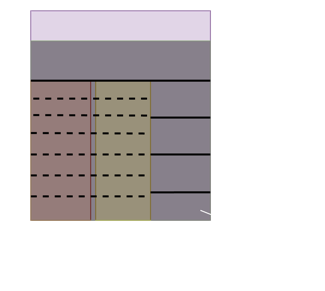
    - This results in a smaller query needed to be made to the Time Series database in the case of a partial hit
    - In the case of a complete cache hit, we can simply manipulate the existing data we have in the cache to return the result to the user.
3. The cache works in these rough steps to produce the output required
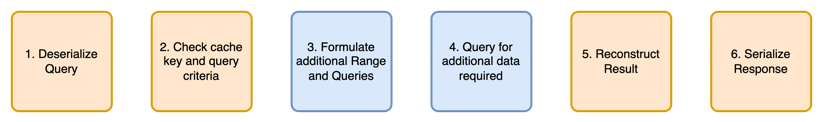

##



In [27]:

from typing import List, Set, Dict
defaultIterations = 100
def runSuiteRaw(queryList: List[InfluxQueryBuilder], client: InfluxDBClient3):
    # Execute the query via client
    startTime = time.time()
    raw_times = []
    results = []
    for query in queryList:
        queryTime = time.time()
        queryStr = query.buildInfluxQlStr()
        table = client.query(query=queryStr, database="Test", language="influxql", mode='pandas')
        endTime = time.time() - queryTime
        raw_times.append(endTime)
        results.append(table)
    rawLatency = time.time() - startTime
    return rawLatency, raw_times

def runSuiteCache(queryList: List[InfluxQueryBuilder]):
    # Execute the query via cache service
    startTime = time.time()
    cached_times = []
    results = []
    queryTraces = []
    for query in queryList:
        queryJson = query.buildJson(doTrace=True)
        queryTime = time.time()
        cacheResp = requests.post(cacheUrlJson, json=queryJson)
        endTime = time.time() - queryTime
        cached_times.append(endTime)
        cacheJson = cacheResp.json()
        tableDf = pd.read_json(json.dumps(cacheJson.get("data")), orient='records')
        queryTrace = cacheJson.get("trace")
        results.append(tableDf)
        queryTraces.append(queryTrace)
    cacheLatency = time.time() - startTime
    return cacheLatency, cached_times, queryTraces

def isOutlier(runLatency, threshold):
    return False #runLatency > threshold

def collateTraces(traces: List[List[Dict[str, int]]]) -> List[Dict[str, float]]:
    sums = [{} for _ in range(len(traces[0]))]
    counts = [{} for _ in range(len(traces[0]))]

    for list_ in traces:
        for i, dict_ in enumerate(list_):
            for key, value in dict_.items():
                if key in sums[i]:
                    sums[i][key] += value
                    counts[i][key] += 1
                else:
                    sums[i][key] = value
                    counts[i][key] = 1

    means = [{} for _ in range(len(traces[0]))]
    for i in range(len(traces[0])):
        for key in sums[i]:
            means[i][key] = sums[i][key] / counts[i][key]
    return means

def collateTracesMedian(traces: List[List[Dict[str, int]]]) -> List[Dict[str, float]]:
    values = [{} for _ in range(len(traces[0]))]

    for list_ in traces:
        for i, dict_ in enumerate(list_):
            for key, value in dict_.items():
                if key in values[i]:
                    values[i][key].append(value)
                else:
                    values[i][key] = [value]

    medians = [{} for _ in range(len(traces[0]))]
    for i in range(len(traces[0])):
        for key in values[i]:
            medians[i][key] = np.median(values[i][key])

    return medians

def runLatencyTest(queryList, iterations, includeFirst=True):
    rawLatencyList = []
    cacheLatencyList = []
    rawTimesList = []
    cachedTimesList = []
    queryTraceList = []
    for i in range(iterations):
        requests.post(resetUrl)
        cacheLatency, cached_times, queryTraces = runSuiteCache(queryList)
        rawLatency, raw_times = runSuiteRaw(queryList, influx_client)
        if not isOutlier(rawLatency, 1):
            rawLatencyList.append(rawLatency)
            rawTimesList.append(raw_times)
        if not isOutlier(cacheLatency, 1):
            cacheLatencyList.append(cacheLatency)
            cachedTimesList.append(cached_times)
            if not includeFirst:
                queryTraces = queryTraces[1:]
            queryTraceList.append(queryTraces)
        #time.sleep(1) #Use this if running the entire notebook at once in order to not exceed influxDB's request limits
    requests.post(resetUrl)
    avg_raw_latency = np.median(rawLatencyList)
    avg_cache_latency = np.median(cacheLatencyList)
    avg_raw_times = np.median(rawTimesList, axis=0)
    avg_cached_times = np.median(cachedTimesList, axis=0)
    avg_query_traces = collateTracesMedian(queryTraceList)
    return avg_raw_latency, avg_cache_latency, avg_raw_times, avg_cached_times, avg_query_traces

def runCorrectnessTest(queryList):
    results = []
    for query in queryList:
        queryStr = query.buildInfluxQlStr()
        queryJson = query.buildJson()
        rawTable = influx_client.query(query=queryStr, database="Test", language="influxql", mode='pandas')
        cacheResp = requests.post(cacheUrlJson, json=queryJson)
        cacheJson = cacheResp.json()
        cacheDf = pd.read_json(json.dumps(cacheJson.get("data")), orient='records')
        results.append([rawTable, cacheDf])
    return results

# 3. Correctness 
We need to prove that the output of our operations don't significantly change the fundamental view a user gets during a query, preserving the rough correctness of the output.
We plot the results of direct queries to InfluxDB against a query via the Cache to show this

In [6]:
correctnessResults = runCorrectnessTest(testQueries)
print(correctnessResults)

[[     iox::measurement                time   host platform  mean_cpu_usage  \
0      system_metrics 2024-05-03 08:22:00  host1   mac_os       16.824000   
1      system_metrics 2024-05-03 08:23:00  host1   mac_os       15.264286   
2      system_metrics 2024-05-03 08:24:00  host1   mac_os        7.771429   
3      system_metrics 2024-05-03 08:25:00  host1   mac_os        7.717857   
4      system_metrics 2024-05-03 08:26:00  host1   mac_os        7.433333   
...               ...                 ...    ...      ...             ...   
1199   system_metrics 2024-05-03 13:18:00  host2  windows       11.702948   
1200   system_metrics 2024-05-03 13:19:00  host2  windows        6.351196   
1201   system_metrics 2024-05-03 13:20:00  host2  windows        6.111485   
1202   system_metrics 2024-05-03 13:21:00  host2  windows       12.039125   
1203   system_metrics 2024-05-03 13:22:00  host2  windows       31.600042   

      mean_temperature  
0            20.150049  
1            19.414316 

/var/folders/s9/kdnfpfqs141dzs9hspp7yhh40000gn/T/ipykernel_51138/3373394764.py:5: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, series in rawSeries:
/var/folders/s9/kdnfpfqs141dzs9hspp7yhh40000gn/T/ipykernel_51138/3373394764.py:5: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, series in rawSeries:
/var/folders/s9/kdnfpfqs141dzs9hspp7yhh40000gn/T/ipykernel_51138/3373394764.py:5: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, series in rawSeries

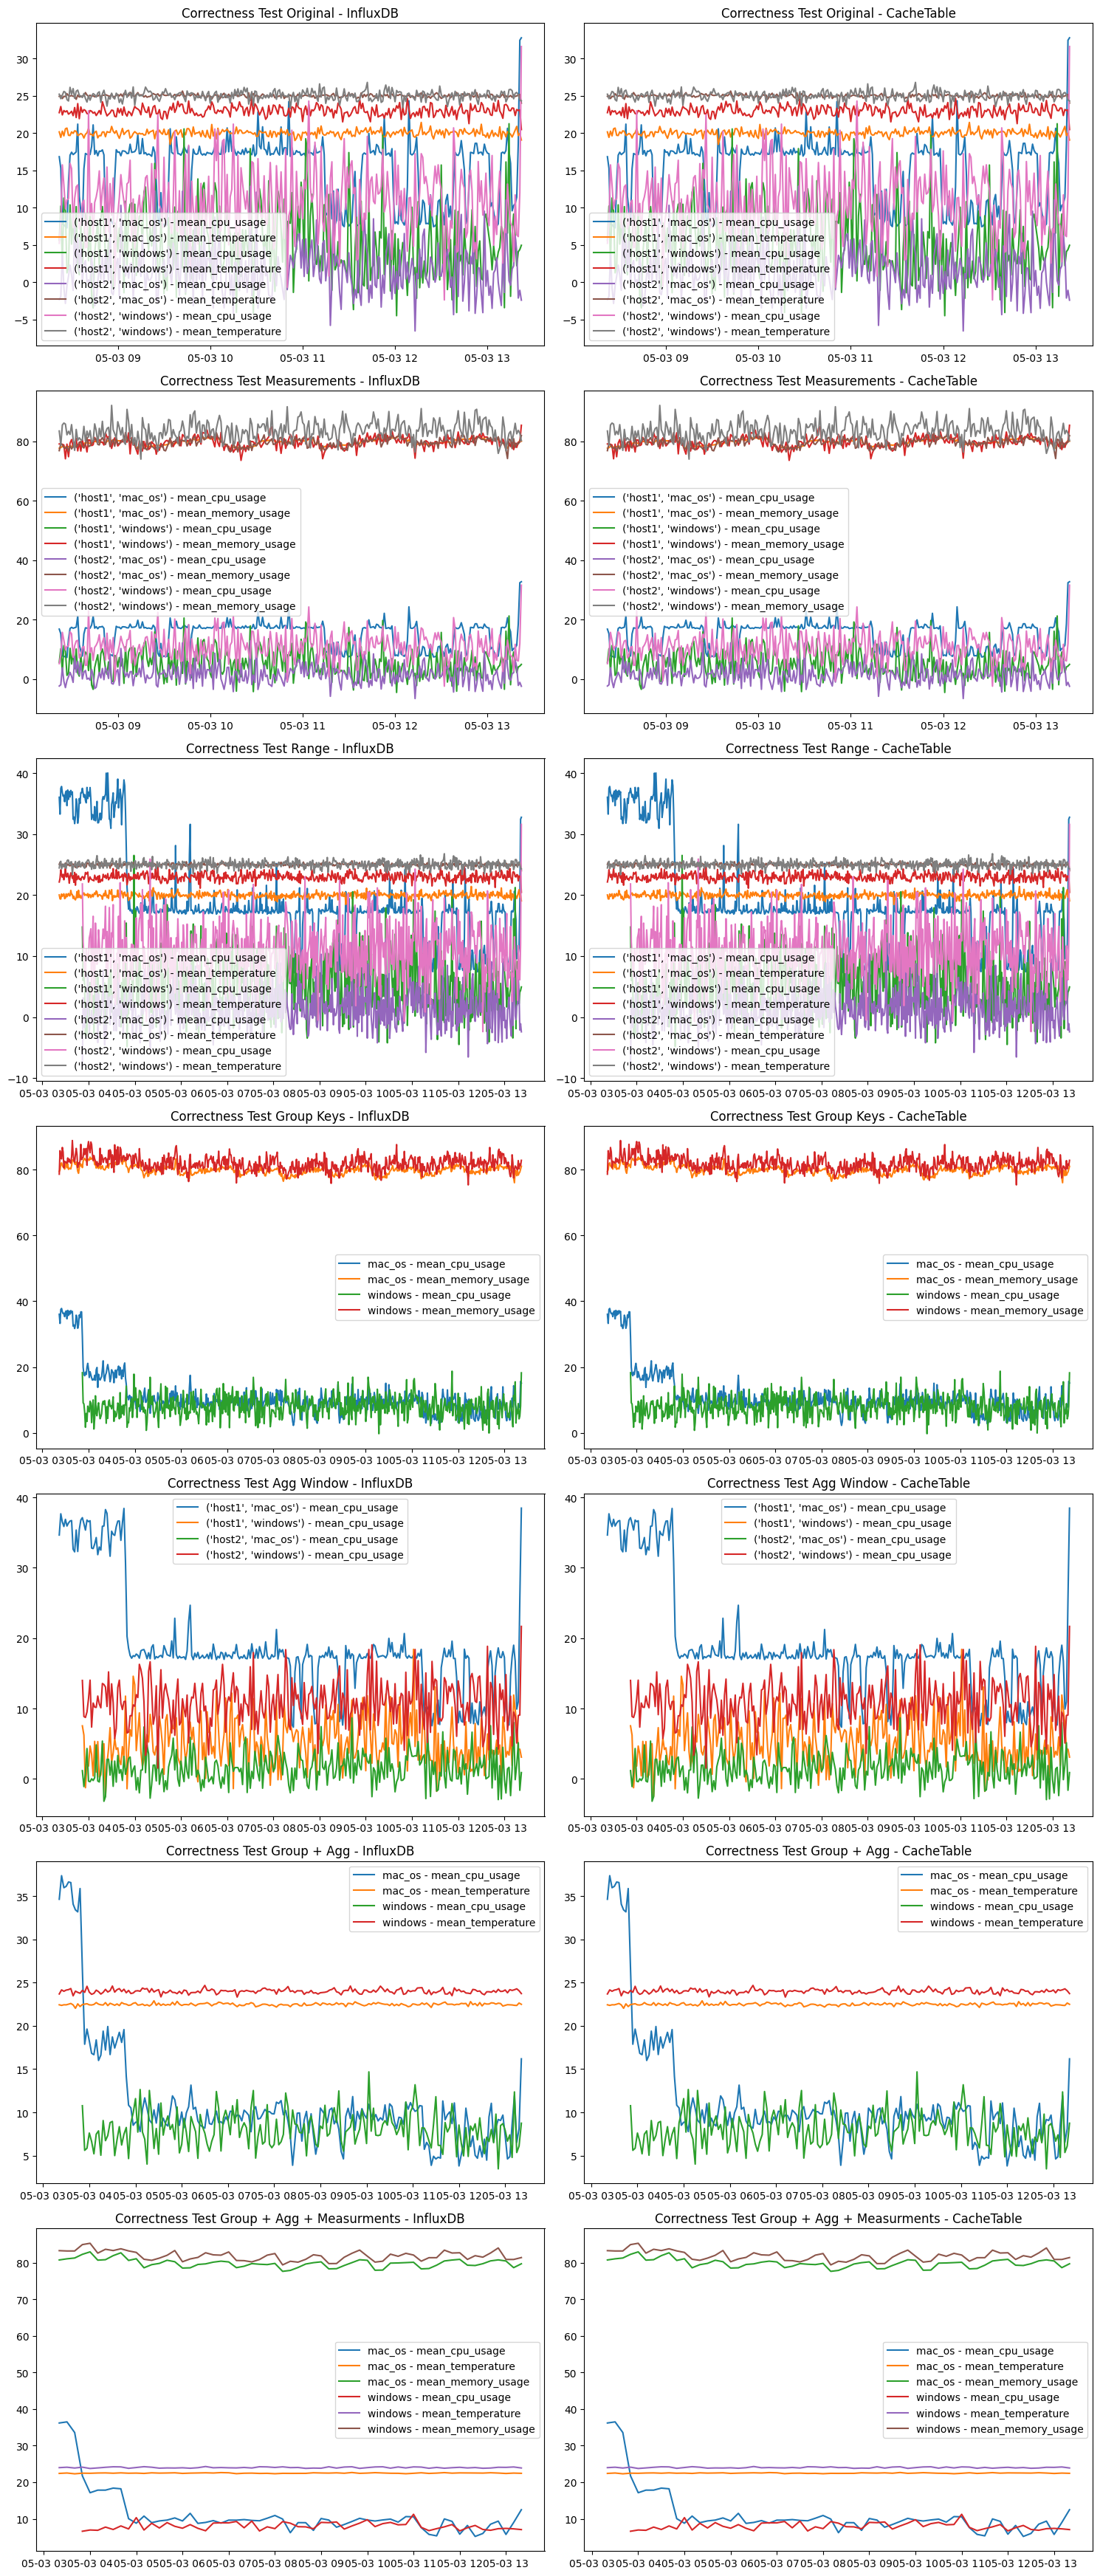

In [7]:
labels = ['Original', 'Measurements', 'Range', 'Group Keys', 'Agg Window', 'Group + Agg', 'Group + Agg + Measurments', 'Total']
def plotDataFrame(graph, df, query, title):
    measurements = [f"{testQuery.aggregate.aggFunc}_{m}" for m in testQuery.measurements]
    rawSeries = rawTable.groupby(testQuery.groupKeys)
    for name, series in rawSeries:
        for measurement in measurements:
            graph.plot(series['time'], series[measurement], label=f"{name} - {measurement}")
    graph.set_title(title)
    graph.legend()

# Plot the results of correctness test
fig, axs = plt.subplots(len(correctnessResults), 2, figsize=(15, len(correctnessResults)*5))

for i, result in enumerate(correctnessResults):
    rawTable = result[0]
    cacheTable = result[1]
    testQuery = testQueries[i]
    label = labels[i]
    plotDataFrame(axs[i, 0], rawTable, testQuery, f"Correctness Test {label} - InfluxDB")
    plotDataFrame(axs[i, 1], cacheTable, testQuery, f"Correctness Test {label} - CacheTable")

plt.tight_layout()
plt.show()

# 4. Latency and Efficiency
1. We want to compare the total latency difference when running the test-suite on InfluxDB against via the Cache
2. In this step, we also show a breakdown of individual query performance for futher analysis

In [8]:
rawLatency, cacheLatency, raw_times, cached_times, avg_query_traces = runLatencyTest(testQueries, defaultIterations)
print("Raw Latency: ", rawLatency)
print("Cache Latency: ", cacheLatency)
print("Raw Times: ", raw_times)
print("Cached Times: ", cached_times)
print("Query Traces: ", avg_query_traces)

Raw Latency:  0.5026760101318359
Cache Latency:  0.29809391498565674
Raw Times:  [0.07053554 0.06723595 0.08318889 0.06573474 0.06128156 0.05798995
 0.05801713]
Cached Times:  [0.10652995 0.01227093 0.08709288 0.01232302 0.01622999 0.0107851
 0.01003051]
Query Traces:  [{'CheckCache': 1.621246337890625e-05, 'CombineAndSet': 0.0007103681564331055, 'InfluxQuery': 0.0944145917892456, 'ReconstructResult': 0.0010641813278198242, 'SerializeResult': 0.0006844997406005859}, {'CheckCache': 2.002716064453125e-05, 'ReconstructResult': 0.0013387203216552734, 'SerializeResult': 0.0006929636001586914}, {'CheckCache': 1.9073486328125e-05, 'CombineAndSet': 0.0016512870788574219, 'InfluxQuery': 0.06768500804901123, 'ReconstructResult': 0.0009601116180419922, 'SerializeResult': 0.0012860298156738281}, {'CheckCache': 2.002716064453125e-05, 'ReconstructResult': 0.0024508237838745117, 'SerializeResult': 0.0006006956100463867}, {'CheckCache': 1.9073486328125e-05, 'ReconstructResult': 0.006934523582458496, '

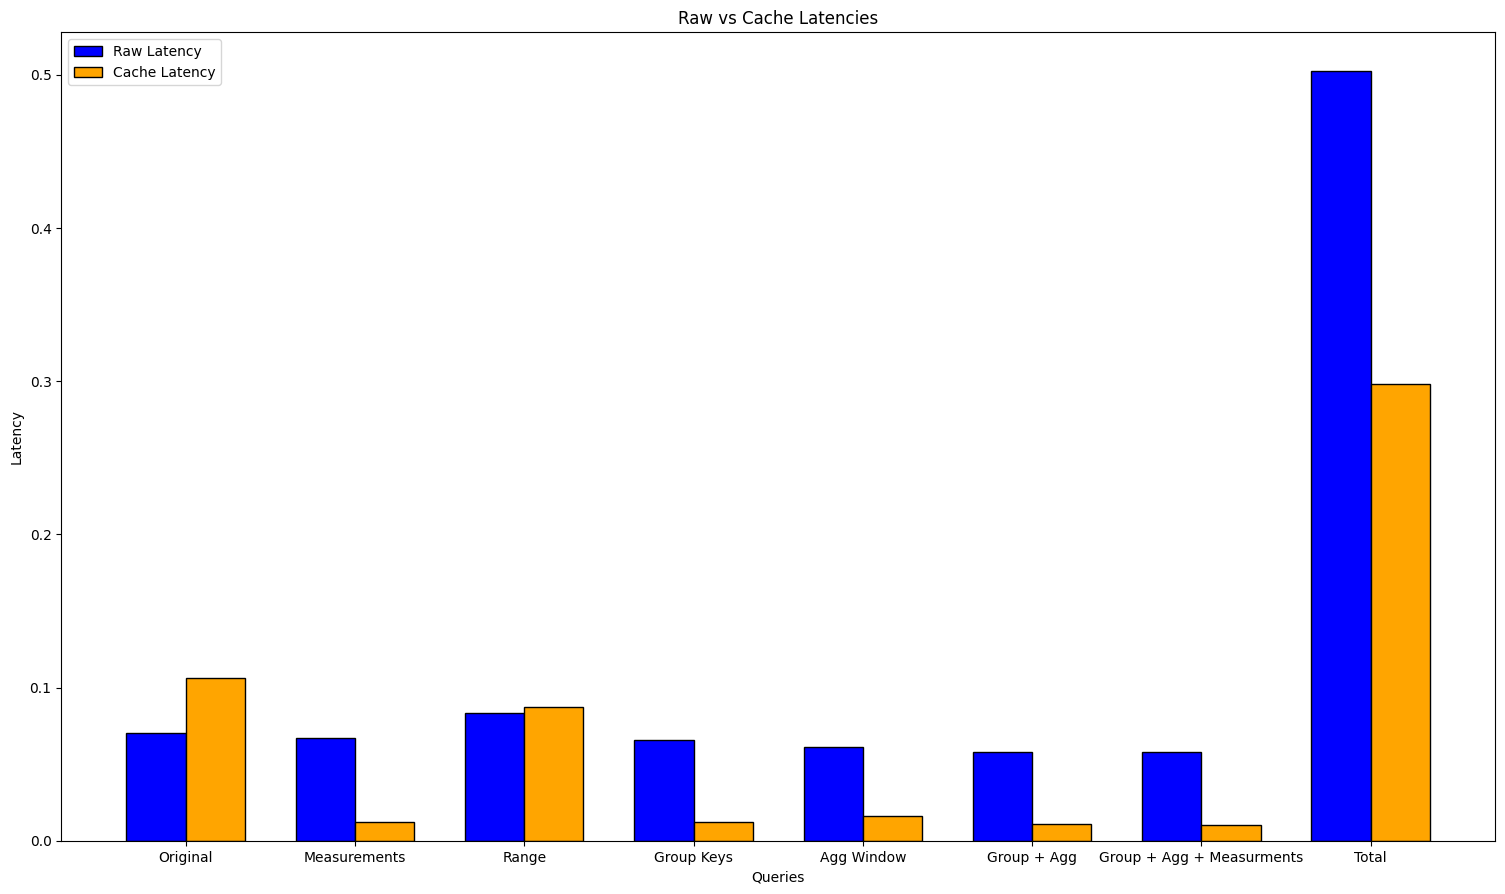

In [9]:
import matplotlib.pyplot as plt

labels = ['Original', 'Measurements', 'Range', 'Group Keys', 'Agg Window', 'Group + Agg', 'Group + Agg + Measurments', 'Total']
all_raw_times = np.append(raw_times, rawLatency)
all_cached_times = np.append(cached_times, cacheLatency)
# Set the width of the bars
bar_width = 0.35

r1 = range(len(all_raw_times))
r2 = [x + bar_width for x in r1]

plt.bar(r1, all_raw_times, color='blue', width=bar_width, edgecolor='black', label='Raw Latency')
plt.bar(r2, all_cached_times, color='orange', width=bar_width, edgecolor='black', label='Cache Latency')

plt.xlabel('Queries')
plt.ylabel('Latency')
plt.title('Raw vs Cache Latencies')
plt.xticks([r + bar_width/2 for r in range(len(labels))], labels)
#Increase figure width
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
# Add a legend
plt.legend()

# Show the plot
plt.show()


## 4.2 Investigating the Impact of Incremental Ranges on Cache performance
1. We see that in the benchmark, the extended range queries do not provide a huge advantage over the direct query to InfluxDB
2. This could be due to the overhead involved in de-and re-serialization of the query, as well as the combination of results in the cache. We then want to investigate the impact of relative incremental ranges.
3. We also implemented tracing in the Cache Server to identify and fix bottlenecks in the execution path which might degrade performance

In [30]:
import importlib
import queryDSL
importlib.reload(queryDSL)
from queryDSL import InfluxQueryBuilder, QueryFilter, QueryAggregation, Range, RelativeRange
from copy import copy


def runRangeLatencyComparison(baseQuery, ranges, iterations=defaultIterations):
    rawLatencies = []
    cacheLatencies = []
    tracesList = []
    for newRange in ranges:
        baseQueryCopy = copy(baseQuery)
        modifiedBuilder = baseQueryCopy.withRelativeRange(newRange.fr, newRange.to)
        rawLatency, cacheLatency, rawLatenciesLs, cacheLatenciesLs, traces = runLatencyTest([baseQuery, modifiedBuilder], iterations, includeFirst=False)
        rawLatencies.append(rawLatenciesLs[1])
        cacheLatencies.append(cacheLatenciesLs[1])
        tracesList.append(traces[0])
    return rawLatencies, cacheLatencies, tracesList

In [31]:

startingRange = 720
baseInfluxBuilder = (InfluxQueryBuilder()
               .withBucket("Test")
               .withMeasurements(["cpu_usage", "temperature"])
               .withTable("system_metrics")
               .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
               .withAggregate(QueryAggregation("1m", "median", False))
               .withRelativeRange(f'{startingRange}m', None)
               .withGroupKeys(["host", "platform"])
       )

additionalRanges = []
for i in range(6):
    addition = 5 * (2 ** i)
    additionalRanges.append(RelativeRange(f'{startingRange + addition}m', None))
print(additionalRanges)
time.sleep(60) # Wait 30 seconds before running next test
range_raws, range_cache, range_traces = runRangeLatencyComparison(baseInfluxBuilder, additionalRanges)
print("Raw Latencies: ", range_raws)
print("Cache Latencies: ", range_cache)
print("RangeTraces: ", range_traces)

[RelativeRange(fr: 725m, to: None), RelativeRange(fr: 730m, to: None), RelativeRange(fr: 740m, to: None), RelativeRange(fr: 760m, to: None), RelativeRange(fr: 800m, to: None), RelativeRange(fr: 880m, to: None)]
Raw Latencies:  [0.09763848781585693, 0.1245349645614624, 0.12120401859283447, 0.1329735517501831, 0.10653746128082275, 0.1025930643081665]
Cache Latencies:  [0.0716094970703125, 0.07164621353149414, 0.09325313568115234, 0.10240662097930908, 0.08924663066864014, 0.09068119525909424]
RangeTraces:  [{'CheckCache': 2.2411346435546875e-05, 'CombineAndSet': 0.0016198158264160156, 'InfluxQuery': 0.05104684829711914, 'ReconstructResult': 0.0011724233627319336, 'SerializeResult': 0.0015119314193725586}, {'CheckCache': 2.276897430419922e-05, 'ReconstructResult': 0.0012145042419433594, 'SerializeResult': 0.0015295743942260742, 'CombineAndSet': 0.0018894672393798828, 'InfluxQuery': 0.057920098304748535}, {'CheckCache': 2.2172927856445312e-05, 'CombineAndSet': 0.0018916130065917969, 'Influx

In [32]:
def plot_comparison(raws, caches, labels, title, xLabel='Queries', yLabel='Latency', traces=None):
    # Set the width of the bars
    bar_width = 0.25

    r1 = range(len(labels))
    r2 = [x + bar_width for x in r1]

    plt.bar(r1, raws, color='blue', width=bar_width, edgecolor='black', label='Raw Latency')
    plt.bar(r2, caches, color='orange', width=bar_width, edgecolor='black', label='Cache Latency')

    opColors = dict()

    if traces is not None:
        for i, operation_dict in enumerate(traces):
            bottom = 0
            for operation, time in operation_dict.items():
                if operation not in opColors:
                    opColors[operation] = np.random.rand(3,)
                plt.bar(i + (bar_width * 2), time, bottom=bottom, color=opColors[operation], width=bar_width, edgecolor='black', label=operation)
                bottom += time
    
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.title(title)
    plt.xticks([r + bar_width/2 for r in range(len(labels))], labels)
    #Increase figure width
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    # Add legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    # Show the plot
    plt.show()

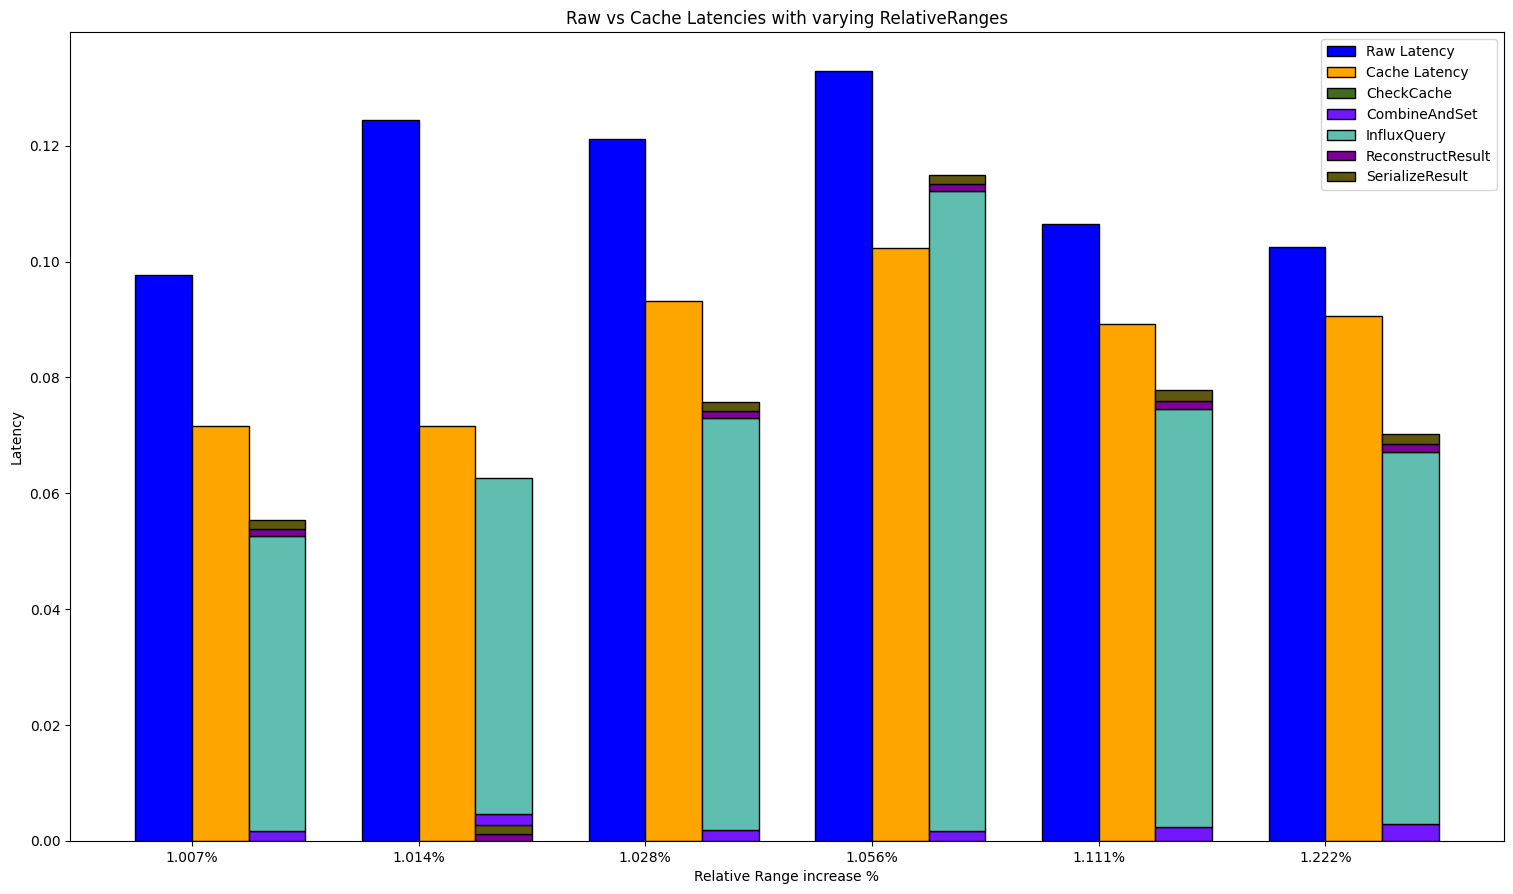

In [33]:
increments = [5, 10, 20, 40, 80, 160]
labels = [format((startingRange + i) / startingRange, ".3f") + "%" for i in increments]
plot_comparison(range_raws, range_cache, labels, "Raw vs Cache Latencies with varying RelativeRanges", "Relative Range increase %", traces=range_traces)

## 4.3 Query size efficiency
1. We want to examine the impact of increasing query sizes on the cache performance.
2. As the data range increases, we examine the impact of using the cache against increasingly larger queries
3. We construct queries with incrementally increasing query sizes to show the increase in efficiency as the size of the query grows.
4. This can be very useful for dashboards utilizing large queries to efficiently retrieve incremental data

In [35]:
#Compare efficiency of cache as query size increases
from builtins import range
starting_ranges = [60, 120, 240, 360, 720, 1440, 2880]

raw_latencies = []
cache_latencies = []
trace_breakdowns = []

for starting_range in starting_ranges:
        baseInfluxBuilder = (InfluxQueryBuilder()
                .withBucket("Test")
                .withMeasurements(["cpu_usage", "temperature"])
                .withTable("system_metrics")
                .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
                .withAggregate(QueryAggregation("1m", "median", False))
                .withRelativeRange(f'{starting_range}m', None)
                .withGroupKeys(["host", "platform"])
        )
        additionalRanges = [RelativeRange(f'{starting_range + 10}m', None)]
        print(f"Starting Range: {starting_range}, Additional Range: {additionalRanges}")
        raw_latency, cache_latency, trace_breakdown = runRangeLatencyComparison(baseInfluxBuilder, additionalRanges, 50)
        raw_latencies.append(raw_latency[0])
        cache_latencies.append(cache_latency[0])
        trace_breakdowns.append(trace_breakdown[0])
        time.sleep(30)

print("Raw Latencies: ", raw_latencies)
print("Cache Latencies: ", cache_latencies)
print("Trace Breakdowns: ", trace_breakdowns)

Starting Range: 60, Additional Range: [RelativeRange(fr: 70m, to: None)]
Starting Range: 120, Additional Range: [RelativeRange(fr: 130m, to: None)]
Starting Range: 240, Additional Range: [RelativeRange(fr: 250m, to: None)]
Starting Range: 360, Additional Range: [RelativeRange(fr: 370m, to: None)]
Starting Range: 720, Additional Range: [RelativeRange(fr: 730m, to: None)]
Starting Range: 1440, Additional Range: [RelativeRange(fr: 1450m, to: None)]
Starting Range: 2880, Additional Range: [RelativeRange(fr: 2890m, to: None)]
Raw Latencies:  [0.07622253894805908, 0.09977197647094727, 0.087211012840271, 0.0892568826675415, 0.18092656135559082, 0.18521952629089355, 0.15403103828430176]
Cache Latencies:  [0.07079100608825684, 0.08785104751586914, 0.06314003467559814, 0.06883001327514648, 0.07360303401947021, 0.13128256797790527, 0.03499913215637207]
Trace Breakdowns:  [{'CheckCache': 2.1457672119140625e-05, 'CombineAndSet': 0.0021169185638427734, 'InfluxQuery': 0.07579898834228516, 'Reconstruc

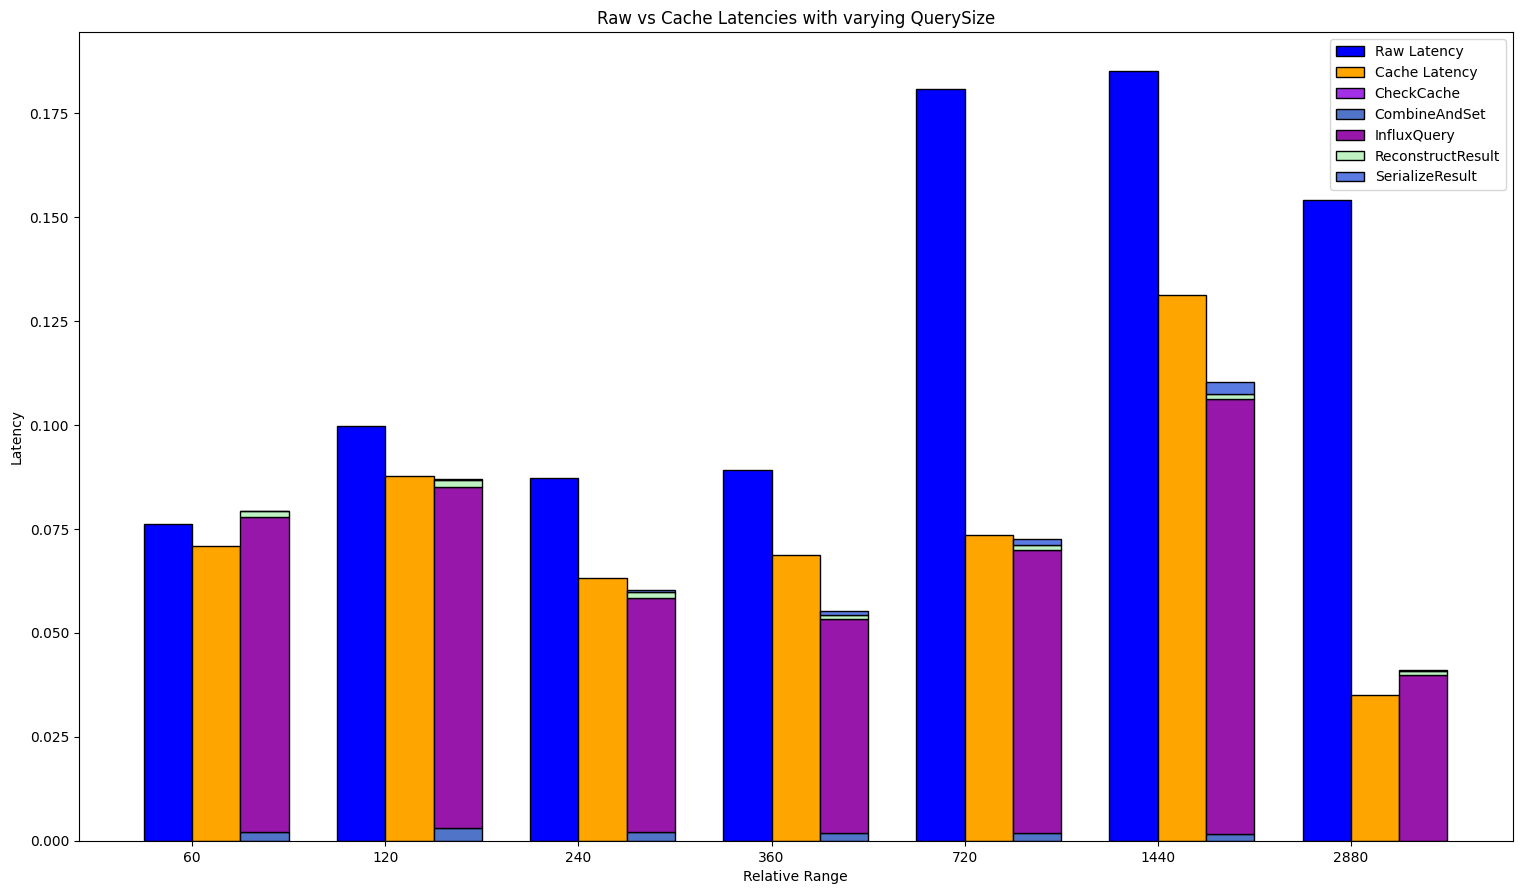

In [37]:
plot_comparison(raw_latencies, cache_latencies, starting_ranges, "Raw vs Cache Latencies with varying QuerySize", "Relative Range", traces=trace_breakdowns)

# Extensions
1. We can extend the cache design to accept writes as well, as a write-through service
    - In all the above tests, the biggest contributor to cache latency was still the extra query needed to be made to InfluxDB.
    - With a write through design, datapoints written to Influx which are relavant to existing queries can be pre-emptively inserted into the cache's tables, removing the need for extra queries.
2. Increased dimensionality of cache
    - Due to the relative high latency required to make a query to Influx, we do not used cached data to return data which differs on multiple dimensions.
3. Filters
    - Since the cache is not aware of the full schema of the underlying data, we are not able to support complex filtering. Using a schema aware cache will allow us to build queries on top of previously filtered data

